## Map classes to the original name

In [ ]:
import os
import pandas as pd

def rename_folders(base_path, label_dict_path):
    # Read the label dictionary
    label_dict_df = pd.read_csv(label_dict_path)
    label_map = dict(zip(label_dict_df['numeric_label'], label_dict_df['class_name']))

    # List and rename folders
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            try:
                # Extract numeric label from folder name and get corresponding class name
                numeric_label = int(folder.split('_')[-1])  # Assuming folder name format 'class_<numeric_label>'
                class_name = label_map.get(numeric_label)

                # Rename folder if class name is found
                if class_name:
                    new_folder_path = os.path.join(base_path, class_name)
                    os.rename(folder_path, new_folder_path)
                    print(f"Renamed '{folder}' to '{class_name}'")
            except (ValueError, IndexError):
                print(f"Skipping non-standard folder: {folder}")

# Usage
base_path = 'gen_l24_31classes'
label_dict_path = 'C:\\Users\\mehrdad\\stylegan3\\~\datasets\l24_classes_512\label_dict.csv'
rename_folders(base_path, label_dict_path)


In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch import nn, optim
import numpy as np
from tqdm import tqdm
from torchvision.models import resnet50, vit_b_16
# Correct import for EfficientNet
from torchvision.models import efficientnet_b0
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Ensure GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

root = 'C:/Users/mehrdad/l24_Imagenet/'
# Load datasets separately
train_dataset = datasets.ImageFolder(root=root + 'test/', transform=transform)
val_dataset = datasets.ImageFolder(root=root + 'val/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


def get_model(model_name, num_classes):
    if model_name == 'vit':
        model = vit_b_16(pretrained=True)
        num_features = model.heads.head.in_features
        model.heads.head = nn.Linear(num_features, num_classes)
    elif model_name == 'resnet50':
        model = resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == 'efficientnet':
        model = efficientnet_b0(pretrained=True)  # Make sure to use the correct EfficientNet version here
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Unknown model name")
    return model.to(device)

# Choose the model to use
# model_name_to_use = 'efficientnet'  # or 'resnet50', 'vit'
model_name_to_use = 'resnet50'  # or 'resnet50', 'vit'

# Use the number of classes from the validation set
num_classes = len(val_dataset.classes)
model = get_model(model_name_to_use, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with tqdm progress bar
for epoch in range(200):  
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1} finished, Loss: {epoch_loss:.4f}')

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Model: {model_name_to_use}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt=".1%", cmap="Blues", cbar=False, xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for {model_name_to_use}")
plt.show()

# Save the trained model
model_filename = f"{model_name_to_use}_{root}.pt"
torch.save(model.state_dict(), model_filename)

## ResNET and EfficientNET

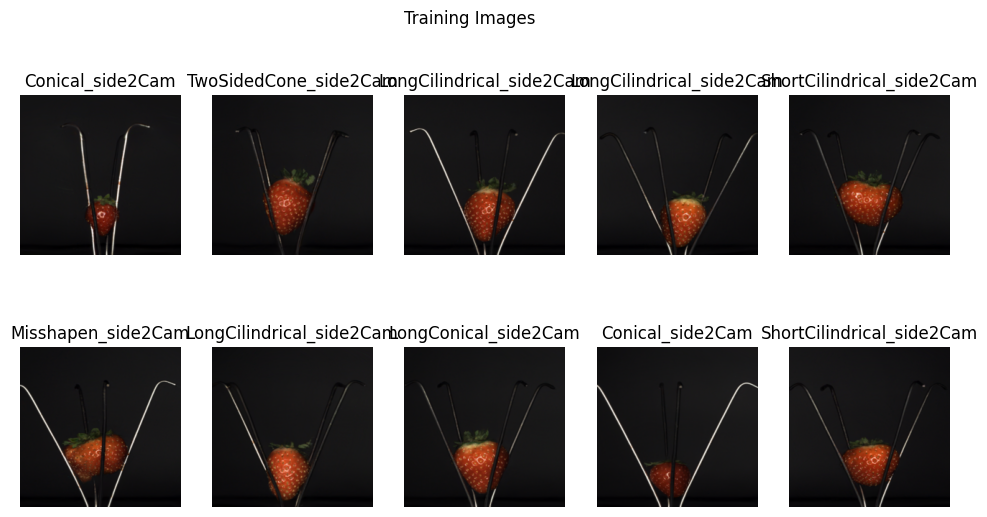

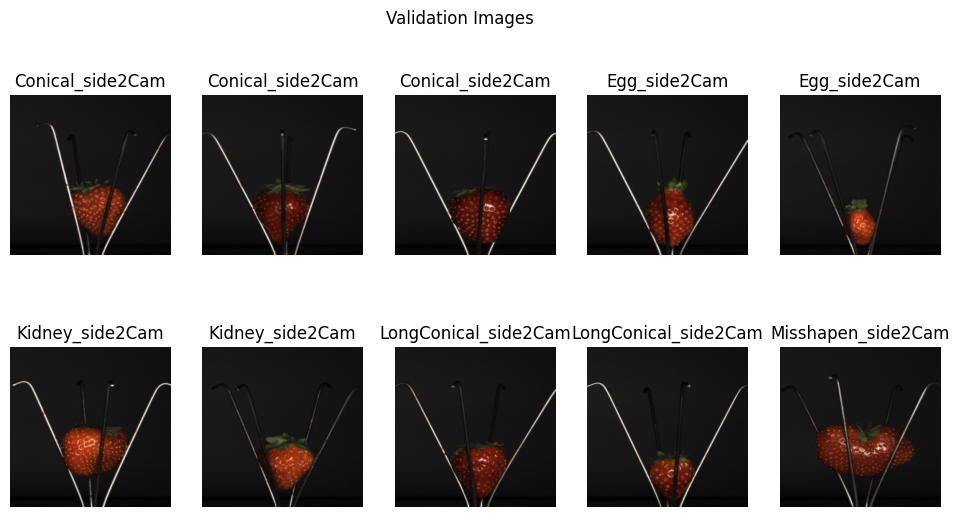

c:\Users\mehrdad\AppData\Local\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 1.9066, Val Loss: 1.7248, Val Accuracy: 0.3577


NameError: name 'all_labels' is not defined

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch import nn, optim
import numpy as np
from tqdm import tqdm
from torchvision.models import resnet50, vit_b_16
# Correct import for EfficientNet
from torchvision.models import efficientnet_b0
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Ensure GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

root = 'C:/Users/mehrdad/l24_Imagenet/'
# Load datasets separately
train_dataset = datasets.ImageFolder(root=root + 'test/', transform=transform)
val_dataset = datasets.ImageFolder(root=root + 'val/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Plot some training images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
train_loader_iter = iter(train_loader)
for i in range(2):
    for j in range(5):
        images, labels = next(train_loader_iter)
        image = images[0].permute(1, 2, 0).cpu().numpy()
        label = val_dataset.classes[labels[0]]
        axes[i, j].imshow(image)
        axes[i, j].set_title(label)
        axes[i, j].axis('off')
plt.suptitle('Training Images')
plt.show()

# Plot some validation images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
val_loader_iter = iter(val_loader)
for i in range(2):
    for j in range(5):
        images, labels = next(val_loader_iter)
        image = images[0].permute(1, 2, 0).cpu().numpy()
        label = val_dataset.classes[labels[0]]
        axes[i, j].imshow(image)
        axes[i, j].set_title(label)
        axes[i, j].axis('off')
plt.suptitle('Validation Images')
plt.show()

def get_model(model_name, num_classes):
    if model_name == 'vit':
        model = vit_b_16(weights=True)
        num_features = model.heads.head.in_features
        model.heads.head = nn.Linear(num_features, num_classes)
    elif model_name == 'resnet50':
        model = resnet50(weights=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == 'efficientnet':
        model = efficientnet_b0(weights=True)  # Make sure to use the correct EfficientNet version here
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Unknown model name")
    return model.to(device)

def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return running_loss / len(dataloader), all_preds, all_labels

# Choose the model to use
model_name_to_use = 'efficientnet'  # or 'resnet50', 'vit'
# model_name_to_use = 'resnet50'  # or 'resnet50', 'vit'

# Use the number of classes from the validation set
num_classes = len(val_dataset.classes)
model = get_model(model_name_to_use, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000005)

# Training loop with tqdm progress bar and validation phase
for epoch in range(1):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    # Validation phase
    val_loss, val_preds, val_labels = evaluate_model(model, val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch+1} finished, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # # Calculate and print metrics at the end of each epoch
    # f1 = f1_score(val_labels, val_preds, average='weighted')
    # print(f"Epoch {epoch+1} Validation Metrics - Accuracy: {val_accuracy:.4f}, F1 Score: {f1:.4f}")
    # print(classification_report(val_labels, val_preds, target_names=val_dataset.classes))


# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Model: {model_name_to_use}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt=".1%", cmap="Blues", cbar=False, xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for {model_name_to_use}")
plt.show()

# Save the trained model
model_filename = f"{model_name_to_use}_{root}.pt"
torch.save(model.state_dict(), model_filename)

## CLiP

In [1]:
import torch
import clip
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ensure GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Update the transform for CLIP
transform = preprocess

root = 'C:/Users/mehrdad/l24_Imagenet/'
# Load datasets separately
train_dataset = datasets.ImageFolder(root=root + 'test/', transform=transform)
val_dataset = datasets.ImageFolder(root=root + 'val/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Define the optimizer
optimizer = torch.optim.Adam(clip_model.parameters(), lr=1e-6)

def train_clip_model(model, dataloader, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Encode text labels
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {train_dataset.classes[label]}") for label in labels]).to(device)

            # Forward pass
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # Calculate loss
            loss = -torch.mean(torch.sum(image_features * text_features, dim=1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Train the model
train_clip_model(clip_model, train_loader, optimizer, epochs=5)

# # Modify the evaluate function as needed for the fine-tuned model
# # ...

# # After training, you can save the fine-tuned model if needed
# torch.save(clip_model.state_dict(), 'fine_tuned_clip_model.pth')


def evaluate_clip_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Encode text labels
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)
            text_features = model.encode_text(text_inputs)

            # Encode images and calculate similarities
            image_features = model.encode_image(images)
            similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            
            # Get the top class for each image
            top_class = similarities.argmax(dim=-1)
            all_preds.extend(top_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluation
val_preds, val_labels = evaluate_clip_model(clip_model, val_loader, val_dataset.classes)
val_accuracy = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
print(classification_report(val_labels, val_preds, target_names=val_dataset.classes))

# ... [Confusion matrix plotting code]



  0%|          | 1/782 [00:12<2:36:15, 12.00s/it]

Epoch [1/5], Loss: -24.9844


  0%|          | 2/782 [00:12<1:06:03,  5.08s/it]

Epoch [1/5], Loss: nan


  0%|          | 3/782 [00:12<37:14,  2.87s/it]  

Epoch [1/5], Loss: nan


  1%|          | 4/782 [00:12<23:42,  1.83s/it]

Epoch [1/5], Loss: nan


  1%|          | 5/782 [00:12<16:14,  1.25s/it]

Epoch [1/5], Loss: nan


  1%|          | 6/782 [00:13<11:44,  1.10it/s]

Epoch [1/5], Loss: nan


  1%|          | 7/782 [00:13<08:53,  1.45it/s]

Epoch [1/5], Loss: nan


  1%|          | 8/782 [00:13<07:01,  1.84it/s]

Epoch [1/5], Loss: nan


  1%|          | 9/782 [00:13<05:46,  2.23it/s]

Epoch [1/5], Loss: nan


  1%|▏         | 10/782 [00:14<04:55,  2.62it/s]

Epoch [1/5], Loss: nan


  1%|▏         | 11/782 [00:14<04:20,  2.96it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 12/782 [00:14<03:56,  3.26it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 13/782 [00:14<03:39,  3.50it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 14/782 [00:15<03:27,  3.70it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 15/782 [00:15<03:20,  3.82it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 16/782 [00:15<03:15,  3.92it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 17/782 [00:15<03:10,  4.02it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 18/782 [00:16<03:07,  4.08it/s]

Epoch [1/5], Loss: nan


  2%|▏         | 19/782 [00:16<03:05,  4.11it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 20/782 [00:16<03:03,  4.15it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 21/782 [00:16<03:04,  4.13it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 22/782 [00:16<03:03,  4.15it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 23/782 [00:17<03:03,  4.14it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 24/782 [00:17<03:02,  4.16it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 25/782 [00:17<03:01,  4.17it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 26/782 [00:17<03:01,  4.17it/s]

Epoch [1/5], Loss: nan


  3%|▎         | 27/782 [00:18<03:00,  4.18it/s]

Epoch [1/5], Loss: nan


  4%|▎         | 28/782 [00:18<02:59,  4.20it/s]

Epoch [1/5], Loss: nan


  4%|▎         | 29/782 [00:18<02:58,  4.22it/s]

Epoch [1/5], Loss: nan


  4%|▍         | 30/782 [00:18<03:07,  4.02it/s]

Epoch [1/5], Loss: nan


  4%|▍         | 31/782 [00:19<03:04,  4.06it/s]

Epoch [1/5], Loss: nan


  4%|▍         | 32/782 [00:19<03:10,  3.93it/s]

Epoch [1/5], Loss: nan


  4%|▍         | 33/782 [00:19<03:12,  3.89it/s]

Epoch [1/5], Loss: nan


  4%|▍         | 34/782 [00:20<03:41,  3.37it/s]

Epoch [1/5], Loss: nan


  4%|▍         | 35/782 [00:20<03:30,  3.56it/s]

Epoch [1/5], Loss: nan


  5%|▍         | 36/782 [00:20<03:25,  3.63it/s]

Epoch [1/5], Loss: nan


  5%|▍         | 37/782 [00:20<03:19,  3.74it/s]

Epoch [1/5], Loss: nan


  5%|▍         | 38/782 [00:21<03:46,  3.29it/s]

Epoch [1/5], Loss: nan


  5%|▍         | 39/782 [00:21<03:31,  3.52it/s]

Epoch [1/5], Loss: nan


  5%|▌         | 40/782 [00:21<03:20,  3.70it/s]

Epoch [1/5], Loss: nan


  5%|▌         | 41/782 [00:21<03:13,  3.82it/s]

Epoch [1/5], Loss: nan


  5%|▌         | 42/782 [00:22<03:54,  3.16it/s]

Epoch [1/5], Loss: nan


  5%|▌         | 43/782 [00:22<03:37,  3.40it/s]

Epoch [1/5], Loss: nan


  6%|▌         | 44/782 [00:22<03:24,  3.60it/s]

Epoch [1/5], Loss: nan


  6%|▌         | 45/782 [00:23<03:17,  3.73it/s]

Epoch [1/5], Loss: nan


  6%|▌         | 46/782 [00:23<03:40,  3.33it/s]

Epoch [1/5], Loss: nan


  6%|▌         | 47/782 [00:23<03:27,  3.54it/s]

Epoch [1/5], Loss: nan


  6%|▌         | 48/782 [00:23<03:19,  3.67it/s]

Epoch [1/5], Loss: nan


  6%|▋         | 49/782 [00:24<03:12,  3.80it/s]

Epoch [1/5], Loss: nan


  6%|▋         | 50/782 [00:24<03:38,  3.35it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 51/782 [00:24<03:25,  3.55it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 52/782 [00:25<03:15,  3.73it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 53/782 [00:25<03:09,  3.85it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 54/782 [00:25<03:33,  3.40it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 55/782 [00:25<03:23,  3.58it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 56/782 [00:26<03:15,  3.72it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 57/782 [00:26<03:09,  3.83it/s]

Epoch [1/5], Loss: nan


  7%|▋         | 58/782 [00:26<03:34,  3.38it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 59/782 [00:27<03:21,  3.59it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 60/782 [00:27<03:13,  3.74it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 61/782 [00:27<03:07,  3.85it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 62/782 [00:27<03:30,  3.41it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 63/782 [00:28<03:19,  3.61it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 64/782 [00:28<03:11,  3.76it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 65/782 [00:28<03:04,  3.88it/s]

Epoch [1/5], Loss: nan


  8%|▊         | 66/782 [00:29<03:30,  3.40it/s]

Epoch [1/5], Loss: nan


  9%|▊         | 67/782 [00:29<03:25,  3.48it/s]

Epoch [1/5], Loss: nan


  9%|▊         | 68/782 [00:29<03:14,  3.67it/s]

Epoch [1/5], Loss: nan


  9%|▉         | 69/782 [00:29<03:11,  3.72it/s]

Epoch [1/5], Loss: nan


  9%|▉         | 70/782 [00:30<03:29,  3.41it/s]

Epoch [1/5], Loss: nan


  9%|▉         | 71/782 [00:30<03:28,  3.41it/s]

Epoch [1/5], Loss: nan


  9%|▉         | 72/782 [00:30<03:16,  3.62it/s]

Epoch [1/5], Loss: nan


  9%|▉         | 73/782 [00:30<03:08,  3.77it/s]

Epoch [1/5], Loss: nan


  9%|▉         | 74/782 [00:31<03:25,  3.45it/s]

Epoch [1/5], Loss: nan


 10%|▉         | 75/782 [00:31<03:29,  3.37it/s]

Epoch [1/5], Loss: nan


 10%|▉         | 76/782 [00:31<03:17,  3.57it/s]

Epoch [1/5], Loss: nan


 10%|▉         | 77/782 [00:32<03:09,  3.72it/s]

Epoch [1/5], Loss: nan


 10%|▉         | 78/782 [00:32<03:26,  3.42it/s]

Epoch [1/5], Loss: nan


 10%|█         | 79/782 [00:32<03:25,  3.43it/s]

Epoch [1/5], Loss: nan


 10%|█         | 80/782 [00:32<03:14,  3.60it/s]

Epoch [1/5], Loss: nan


 10%|█         | 81/782 [00:33<03:11,  3.67it/s]

Epoch [1/5], Loss: nan


 10%|█         | 82/782 [00:33<03:25,  3.40it/s]

Epoch [1/5], Loss: nan


 11%|█         | 83/782 [00:33<03:29,  3.34it/s]

Epoch [1/5], Loss: nan


 11%|█         | 84/782 [00:34<03:15,  3.57it/s]

Epoch [1/5], Loss: nan


 11%|█         | 85/782 [00:34<03:07,  3.71it/s]

Epoch [1/5], Loss: nan


 11%|█         | 86/782 [00:34<03:19,  3.48it/s]

Epoch [1/5], Loss: nan


 11%|█         | 87/782 [00:34<03:22,  3.43it/s]

Epoch [1/5], Loss: nan


 11%|█▏        | 88/782 [00:35<03:12,  3.61it/s]

Epoch [1/5], Loss: nan


 11%|█▏        | 89/782 [00:35<03:05,  3.73it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 90/782 [00:35<03:17,  3.50it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 91/782 [00:36<03:16,  3.51it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 92/782 [00:36<03:07,  3.68it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 93/782 [00:36<03:00,  3.82it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 94/782 [00:36<03:16,  3.50it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 95/782 [00:37<03:15,  3.52it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 96/782 [00:37<03:05,  3.70it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 97/782 [00:37<02:58,  3.84it/s]

Epoch [1/5], Loss: nan


 12%|█▏        | 97/782 [00:39<04:36,  2.48it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import dnnlib
import legacy
from viz.renderer import Renderer

def load_model_from_snapshot(snapshot_pkl):
    with dnnlib.util.open_url(snapshot_pkl) as f:
        model = legacy.load_network_pkl(f)['G_ema']  # Assuming G_ema is the generator model
    return model

def extract_layer_output(model, layer_name):
    renderer = Renderer()

    # Determine the device from the model's parameters
    device = next(model.parameters()).device

    # Example random input with appropriate shape
    batch_size = 32
    num_ws = model.num_ws
    w_dim = model.synthesis.w_dim
    random_input = torch.randn([batch_size, num_ws, w_dim], device=device)

    layer_output, _ = renderer.run_synthesis_net(model.synthesis, random_input, capture_layer=layer_name)
    return layer_output



# Usage
snapshot_pkl = '~/training-runs/00045-stylegan3-t-Retinal_Fundus_imagenet_val-gpus1-batch32-gamma2/network-snapshot-001500.pkl' 
model = load_model_from_snapshot(snapshot_pkl)
layer_name = 'L13_256_64'
# layer_name = 'L12_275_64'
layer_output = extract_layer_output(model, layer_name)
print(layer_output.shape)


In [ ]:
import numpy as np

def generate_latent_vector(seed, z_dim, c_dim=0, class_label=None):
    # Generate a latent vector from the given seed
    rnd = np.random.RandomState(seed)
    z = torch.from_numpy(rnd.randn(1, z_dim)).float()  # Shape: [1, z_dim]

    # Generate class label if necessary
    c = None
    if c_dim > 0:
        c = torch.zeros(1, c_dim)
        if class_label is not None:
            c[0, class_label] = 1  # Set the specified class label
        else:
            c[0, rnd.randint(c_dim)] = 1  # Random class if not specified
    return z, c

def extract_layer_output(model, layer_name, z, c=None):
    renderer = Renderer()
    device = next(model.parameters()).device
    z = z.to(device)
    if c is not None:
        c = c.to(device)

    # Generate the intermediate latent vector w
    with torch.no_grad():
        w = model.mapping(z, c, truncation_psi=1)  # You can adjust truncation_psi as needed

    # Extract the layer output
    layer_output, _ = renderer.run_synthesis_net(model.synthesis, w, capture_layer=layer_name)
    return layer_output

# Example usage
seed = 0  # Example seed
z_dim = model.z_dim  # From your model
c_dim = model.c_dim  # From your model, set to 0 if not using class labels
class_label = 15  # Set to a specific class label if needed

z, c = generate_latent_vector(seed, z_dim, c_dim, class_label)
layer_output = extract_layer_output(model, layer_name, z, c)

In [ ]:
# subplot for random 16 images from the layer output
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, rows, cols, figsize=(10, 10)):
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    for i, image in enumerate(images):
        ax[i // cols, i % cols].imshow(image)
        ax[i // cols, i % cols].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage

plot_images(layer_output[0, 0:16], rows=4, cols=4)


In [ ]:
model_filename = f"{model_name_to_use}.pt"

# Predict function for test_crassiflora images
def predict_test_crassiflora(model_name, trained_model_path):
    # Load the model architecture
    model = get_model(model_name, len(dataset.classes))
    
    # Load the trained model weights or full model
    checkpoint = torch.load(trained_model_path)
    if isinstance(checkpoint, dict):
        # If the checkpoint is a dict, load the state dict
        model.load_state_dict(checkpoint)
    elif isinstance(checkpoint, torch.nn.Module):
        # If the checkpoint is a Module, it's the whole model
        model = checkpoint
    else:
        raise TypeError("Unsupported type for the loaded checkpoint.")
    
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Create a dataset for test_crassiflora
    test_crassiflora_dataset = datasets.ImageFolder(
        root='test_crassiflora',
        transform=transform
    )

    # Assume class_to_idx is the same as in the original training dataset
    # This is important to ensure labels match between training and prediction
    class_to_idx = dataset.class_to_idx

    # Create a dataloader for test_crassiflora
    test_crassiflora_loader = DataLoader(test_crassiflora_dataset, batch_size=32, shuffle=False)

    # Predict labels for test_crassiflora
    predictions = []
    with torch.no_grad():
        for inputs, _ in tqdm(test_crassiflora_loader, desc='Predicting'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Map indices to the correct class labels
            predicted_labels = [list(class_to_idx.keys())[list(class_to_idx.values()).index(p)] for p in preds.cpu().numpy()]
            predictions.extend(predicted_labels)

    # Optionally save or print predictions
    for img, pred in zip(test_crassiflora_dataset.imgs, predictions):
        print(f'Image: {img[0]}, Predicted label: {pred}')

# Call the function to make predictions on test_crassiflora
predict_test_crassiflora(model_name_to_use, model_filename)
